In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
from onix.analysis.probe import Probe
from onix.analysis.fitter import Fitter
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold, present_float
from onix.models.hyperfine import energies

In [2]:
name = "EO Wide Scan"
analysis_number = None
identifier = None

In [3]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

In [49]:
def data_to_probe(data_number):
    data_index = data_numbers.index(data_number)
    data, headers = all_data[data_index]
    repeats = ["sweep", "carrier_burn", "burn", "burn1", "flop"]
    probe_repeats = headers["params"]["detect"]["repeats"]
    repeats = dict([(kk, probe_repeats) for kk in repeats])
    p = Probe(data["times"], data["transmissions"], repeats, data["monitors"])
    p.transmission_groups["carrier_burn_no_bg"] = p.transmission_groups["carrier_burn"] - p.transmission_groups["sweep"]
    p.monitor_groups["carrier_burn_no_bg"] = p.monitor_groups["carrier_burn"] - p.monitor_groups["sweep"]
    p.transmission_groups["burn_no_bg"] = p.transmission_groups["burn"] - p.transmission_groups["carrier_burn"]
    p.monitor_groups["burn_no_bg"] = p.monitor_groups["burn"] - p.monitor_groups["carrier_burn"]
    p.transmission_groups["burn1_no_bg"] = p.transmission_groups["burn1"] - p.transmission_groups["burn"]
    p.monitor_groups["burn1_no_bg"] = p.monitor_groups["burn1"] - p.monitor_groups["burn"]
    p.transmission_groups["burn1_no_bg1"] = p.transmission_groups["burn1"] - p.transmission_groups["carrier_burn"]
    p.monitor_groups["burn1_no_bg1"] = p.monitor_groups["burn1"] - p.monitor_groups["carrier_burn"]
    p.transmission_groups["flop_no_bg"] = p.transmission_groups["flop"] - p.transmission_groups["burn1"]
    p.monitor_groups["flop_no_bg"] = p.monitor_groups["flop"] - p.monitor_groups["burn1"]

    pre_probe_delay = headers["params"]["detect"]["ttl_detect_offset_time"].to("s").magnitude
    on_time = headers["params"]["detect"]["on_time"].to("s").magnitude
    off_time = headers["params"]["detect"]["off_time"].to("s").magnitude
    rise_delay = 2e-6
    fall_delay = 1e-6
    probe_detunings = headers["params"]["detect"]["detunings"].to("MHz").magnitude
    p.set_probe_times(pre_probe_delay, on_time, off_time, rise_delay, fall_delay, probe_detunings)
    return p

In [113]:
#data_numbers = [837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848]
data_numbers = [917]
all_data = [get_experiment_data(kk) for kk in data_numbers]
probes = [data_to_probe(kk) for kk in data_numbers]
identifier = "data " + data_identifier(data_numbers)# + ", analysis " + data_identifier([analysis_number])

In [114]:
index = 0
p = probes[index]
data_number = data_numbers[index]

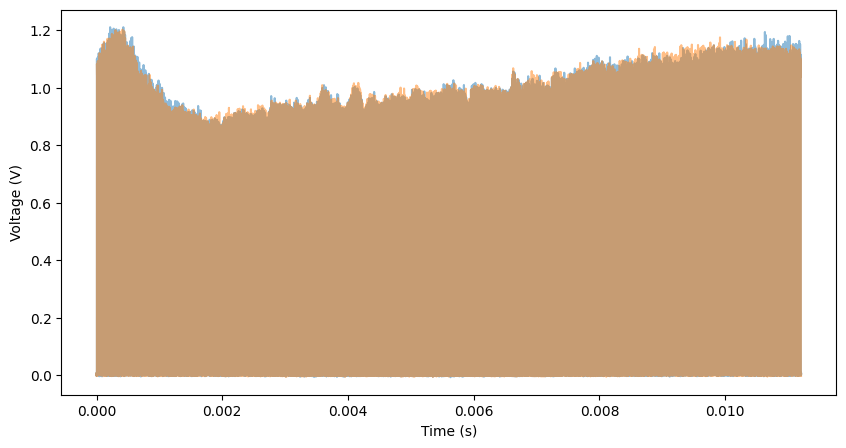

In [115]:
fig, ax = plt.subplots(figsize=(10, 5))
group_name = "sweep"
reshape_size = (
    p.transmission_groups[group_name].shape[0] * p.transmission_groups[group_name].shape[1],
    p.transmission_groups[group_name].shape[2]
)
ax.plot(p.times, p.transmission_groups[group_name].reshape(*reshape_size)[:].T, alpha=0.5)
#ax.set_xlim(0, 0.00001)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (V)")
plt.show()

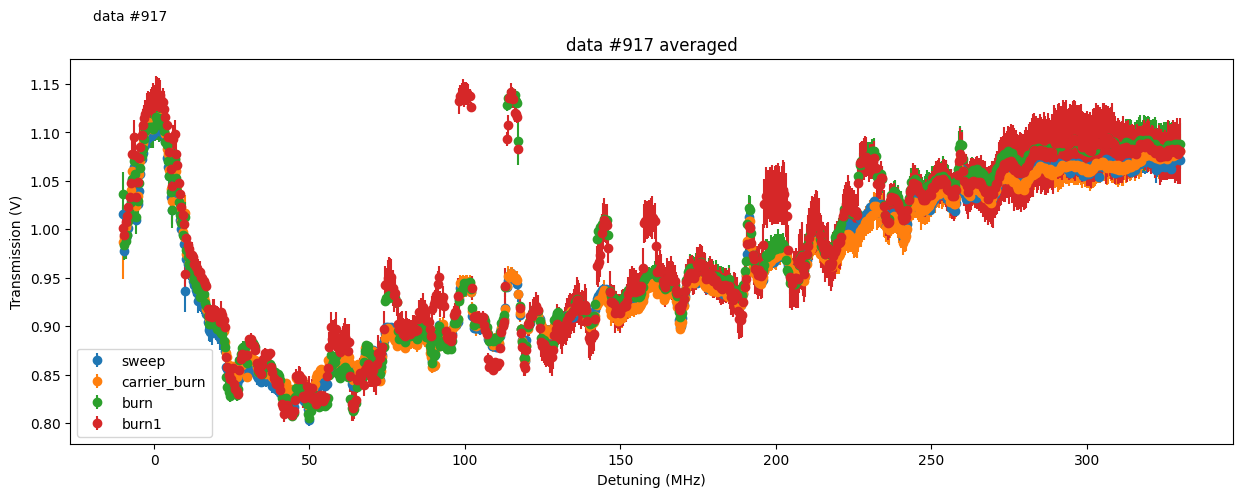

In [116]:
fig, ax = plt.subplots(figsize=(15, 5))
add_label(ax)
ax.errorbar(p.probes, p.averages("sweep"), p.errors("sweep"), label="sweep", ls="none", marker="o")
ax.errorbar(p.probes, p.averages("carrier_burn"), p.errors("carrier_burn"), label="carrier_burn", ls="none", marker="o")
ax.errorbar(p.probes, p.averages("burn"), p.errors("burn"), label="burn", ls="none", marker="o")
ax.errorbar(p.probes, p.averages("burn1"), p.errors("burn1"), label="burn1", ls="none", marker="o")
ax.legend()
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
ax.set_title(f"data #{data_number} averaged")
plt.show()

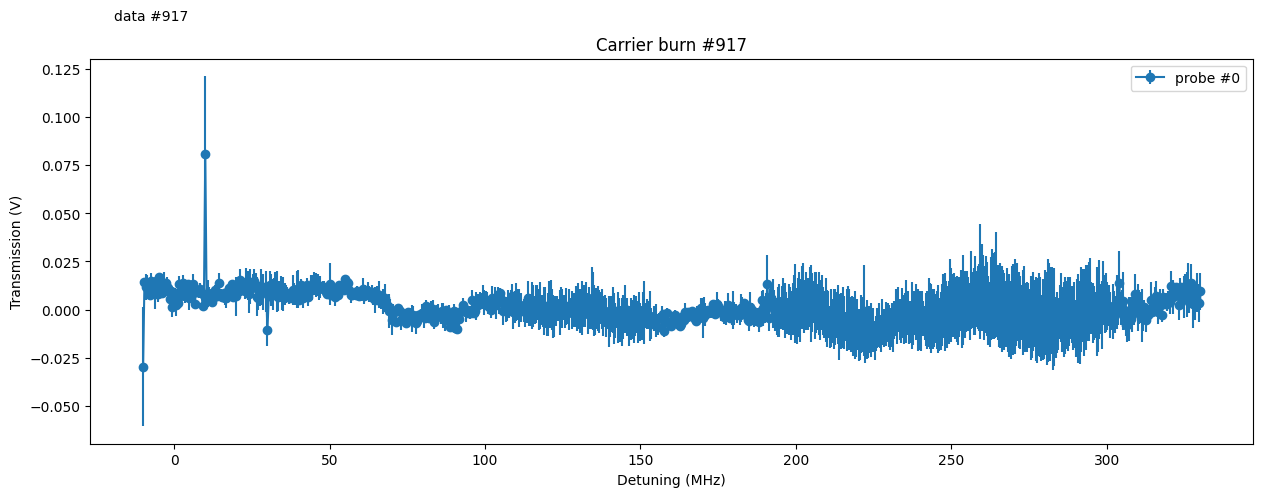

In [117]:
fig, ax = plt.subplots(figsize=(15, 5))
add_label(ax)
zorder = 100
for kk in range(len(p.averages("carrier_burn_no_bg", mode="probe_repeats"))):
    signal = p.averages("carrier_burn_no_bg", mode="probe_repeats")[kk]
    error = p.errors("carrier_burn_no_bg", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"probe #{kk}", marker="o", zorder=zorder-kk)
ax.legend()
ax.set_title(f"Carrier burn #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
plt.show()

In [118]:
burn_freq = all_data[index][1]["params"]["burn1"]["detuning"]
test_freq = burn_freq.to("MHz").magnitude
holes = []
antiholes = []
for F_state in ["a", "b", "c"]:
    for D_state in ["a", "b", "c"]:
        zero_frequency = test_freq - (energies["5D0"][D_state] - energies["7F0"][F_state]).to("MHz").magnitude
        for other_F_state in ["a", "b", "c"]:
            if other_F_state == F_state:
                for other_D_state in ["a", "b", "c"]:
                    holes.append(zero_frequency + (energies["5D0"][other_D_state] - energies["7F0"][other_F_state]).to("MHz").magnitude)
            else:
                for other_D_state in ["a", "b", "c"]:
                    antiholes.append(zero_frequency + (energies["5D0"][other_D_state] - energies["7F0"][other_F_state]).to("MHz").magnitude)
                    print(f"{F_state} -> {D_state} pump, {other_F_state} -> {other_D_state} probe, {antiholes[-1]}")
holes = np.array(holes)
antiholes = np.array(antiholes)

a -> a pump, b -> a probe, -19.19999999999999
a -> a pump, b -> b probe, -279.2
a -> a pump, b -> c probe, -473.2
a -> a pump, c -> a probe, -109.25
a -> a pump, c -> b probe, -369.25
a -> a pump, c -> c probe, -563.25
a -> b pump, b -> a probe, 240.8
a -> b pump, b -> b probe, -19.200000000000003
a -> b pump, b -> c probe, -213.2
a -> b pump, c -> a probe, 150.75
a -> b pump, c -> b probe, -109.25
a -> b pump, c -> c probe, -303.25
a -> c pump, b -> a probe, 434.8
a -> c pump, b -> b probe, 174.8
a -> c pump, b -> c probe, -19.200000000000003
a -> c pump, c -> a probe, 344.75
a -> c pump, c -> b probe, 84.75
a -> c pump, c -> c probe, -109.25
b -> a pump, a -> a probe, 219.2
b -> a pump, a -> b probe, -40.80000000000001
b -> a pump, a -> c probe, -234.8
b -> a pump, c -> a probe, 9.949999999999989
b -> a pump, c -> b probe, -250.05
b -> a pump, c -> c probe, -444.05
b -> b pump, a -> a probe, 479.2
b -> b pump, a -> b probe, 219.2
b -> b pump, a -> c probe, 25.200000000000003
b -> b p

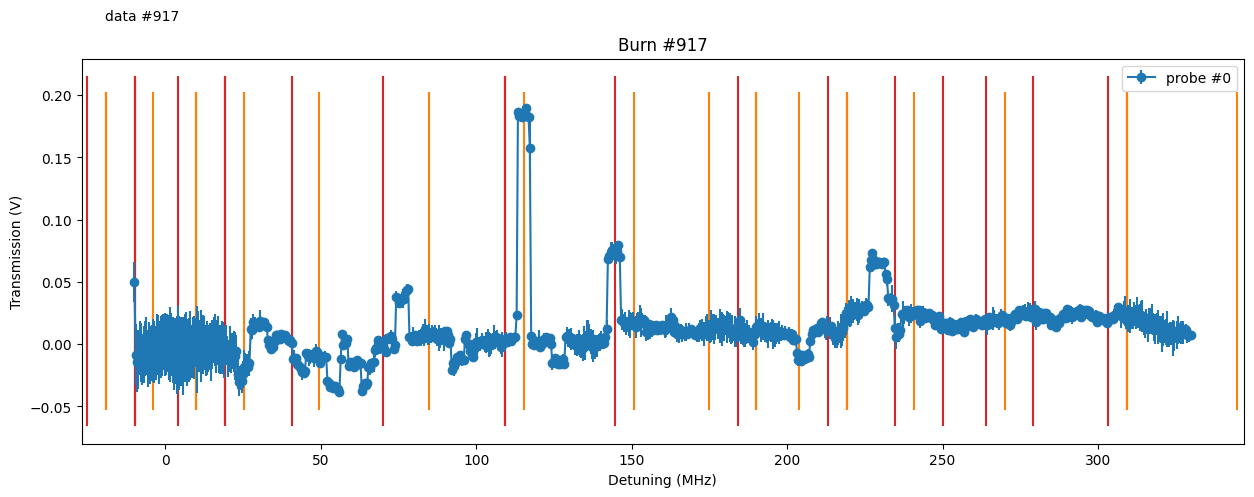

In [119]:
fig, ax = plt.subplots(figsize=(15, 5))
add_label(ax)
zorder = 100
for kk in range(len(p.averages("burn_no_bg", mode="probe_repeats"))):
    signal = p.averages("burn_no_bg", mode="probe_repeats")[kk]
    error = p.errors("burn_no_bg", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"probe #{kk}", marker="o", zorder=zorder-kk)
    ax.yaxis.use_sticky_edges = True
    xlim = ax.get_xlim()
    #ax.vlines([holes], *ax.get_ylim(), color="C1")
    #ax.vlines([-holes], *ax.get_ylim(), color="C2")
    #ax.vlines([holes / 2], *ax.get_ylim(), color="C2")
    #ax.vlines([-holes / 2], *ax.get_ylim(), color="C4")
    ax.vlines([antiholes], *ax.get_ylim(), color="C1")
    #ax.vlines([625 - antiholes], *ax.get_ylim(), color="C2")
    #ax.vlines([antiholes / 2], *ax.get_ylim(), color="C2")
    ax.vlines([-antiholes], *ax.get_ylim(), color="C3")
    #ax.vlines([-antiholes / 2], *ax.get_ylim(), color="C4")
    ax.set_xlim(*xlim)
ax.legend()
ax.set_title(f"Burn #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
#ax.set_xlim(45, 60)
plt.show()

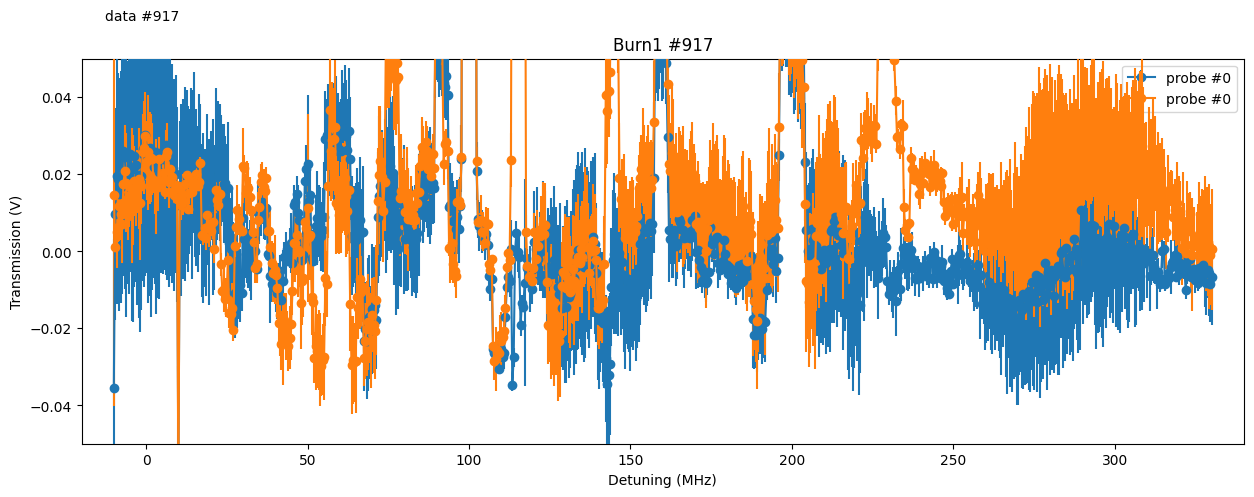

In [120]:
fig, ax = plt.subplots(figsize=(15, 5))
add_label(ax)
zorder = 100
for kk in range(len(p.averages("burn1_no_bg", mode="probe_repeats"))):
    signal = p.averages("burn1_no_bg", mode="probe_repeats")[kk]
    error = p.errors("burn1_no_bg", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"probe #{kk}", marker="o", zorder=zorder-kk)
    signal = p.averages("burn1_no_bg1", mode="probe_repeats")[kk]
    error = p.errors("burn1_no_bg1", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"probe #{kk}", marker="o", zorder=zorder-kk)
    #ax.vlines([holes], *ax.get_ylim(), color="C1")
    #ax.vlines([-holes], *ax.get_ylim(), color="C2")
    #ax.vlines([holes / 2], *ax.get_ylim(), color="C2")
    #ax.vlines([-holes / 2], *ax.get_ylim(), color="C4")
ax.legend()
ax.set_title(f"Burn1 #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
#ax.set_xlim(45, 60)
ax.set_xlim(-20, 340)
ax.set_ylim(-0.05, 0.05)
plt.show()

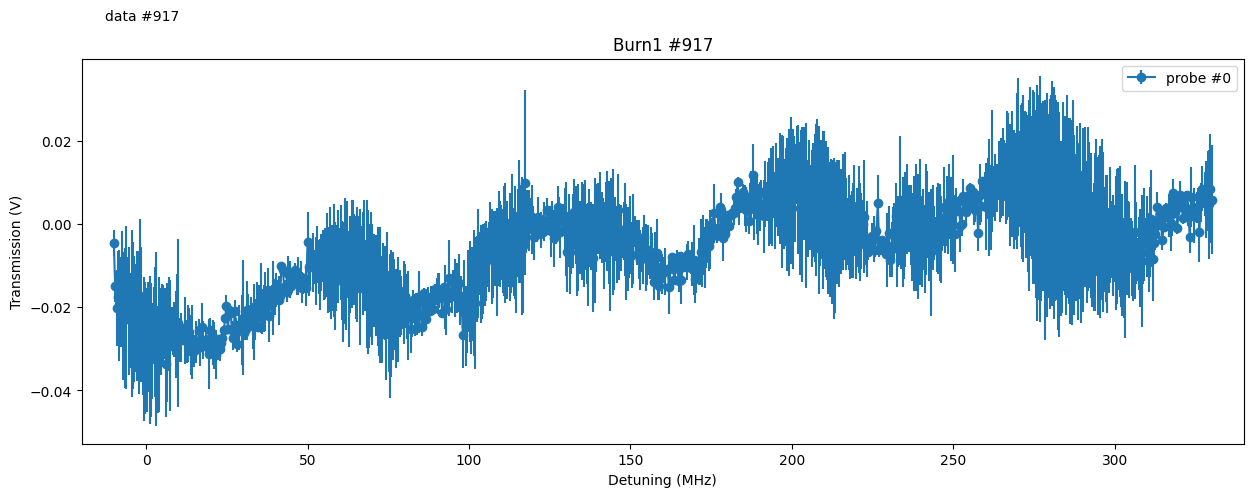

In [121]:
fig, ax = plt.subplots(figsize=(15, 5))
add_label(ax)
zorder = 100
for kk in range(len(p.averages("burn1_no_bg", mode="probe_repeats"))):
    signal = p.averages("flop_no_bg", mode="probe_repeats")[kk]
    error = p.errors("flop_no_bg", mode="probe_repeats")[kk]
    ax.errorbar(p.probes, signal, error, label=f"probe #{kk}", marker="o", zorder=zorder-kk)
ax.legend()
ax.set_title(f"Burn1 #{data_number}")
ax.set_xlabel("Detuning (MHz)")
ax.set_ylabel("Transmission (V)")
ax.set_xlim(-20, 340)
#ax.set_xlim(45, 60)
#ax.set_xlim(45, 60)
plt.show()